**Table of contents**<a id='toc0_'></a>    
- [Import Libraries](#toc1_1_1_)    
- [Defined Canny Edge Detector Class](#toc1_1_2_)    
- [Load Images](#toc1_1_3_)    
- [Train-Test Split](#toc1_1_4_)    
- [Model Training](#toc1_1_5_)    
- [Model Evaluation](#toc1_1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -a '/content/drive/MyDrive/Prachi/' '/content/'

In [3]:
import zipfile
import os
# loading and extracting data
os.makedirs("/content/data/", exist_ok=True)

zip_ref = zipfile.ZipFile("/content/Prachi/Train.zip", 'r')
zip_ref.extractall("/content/data/")
zip_ref.close()

In [4]:
!pip install torch torchvision timm dagshub mlflow
!pip install torch-summary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### <a id='toc1_1_1_'></a>[Import Libraries](#toc0_)

In [7]:
import torch
import timm
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, matthews_corrcoef, ConfusionMatrixDisplay
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import mlflow
import mlflow.pytorch
import os
from tqdm import tqdm
import dagshub
#  dagshub.init(repo_owner='shriganesh.patel', repo_name='Dermnet', mlflow=True)
dagshub.init(repo_owner='prachipancholi1', repo_name='Dermnet', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=e5a24081-b91b-4c89-ba9f-064db072d79c&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=821495de2ea393989fbbd62353d5608a89d16b002384bfbf656b9b8eac8135d3




Accessing as prachipancholi1

Initialized MLflow to track repo "prachipancholi1/Dermnet"

Repository prachipancholi1/Dermnet initialized!

In [8]:
# Step 1: Define transformations for preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 (ResNet's expected input size)
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize based on ImageNet stats
])

In [9]:
# Load the dataset (all images)
dataset = datasets.ImageFolder(root='/content/data/Train', transform=transform)

In [10]:
# Verify class names
print("Classes:", dataset.classes)  # Should print ['Eczema', 'Psoriasis', 'Seborrheic_Keratoses']
num_classes = len(dataset.classes)

Classes: ['Eczema', 'Psoriasis', 'Seborrheic_Keratoses']


In [11]:
# Step 3: Create indices and split with `train_test_split`
indices = list(range(len(dataset)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

# Create Subsets
train_data = Subset(dataset, train_indices)
test_data = Subset(dataset, test_indices)

In [12]:
# Step 3: Create Data Loader for training and test dataset
train_dataloader = DataLoader(train_data, batch_size = 32, shuffle = True, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True, num_workers=2)

In [13]:
# Step 4: Load the pre-trained Resnet model using timm
resnet = timm.create_model('resnet18', pretrained=True) # Load ResNet18 from timm

# Freeze all layers ex[ect the final fully connected layer
for param in resnet.parameters():
    param.requires_grad = False

# Modify the fully connected layer to match the number of classes
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, len(dataset.classes))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [14]:
# Step 6: Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [15]:
print(device)

cuda


In [16]:
# print the model summary
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

# Print model summary
print(summary(resnet, input_size=(3, 224, 224)))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  (36,864)
|    |    └─BatchNorm2d: 3-2             (128)
|    |    └─Identity: 3-3                --
|    |    └─ReLU: 3-4                    --
|    |    └─Identity: 3-5                --
|    |    └─Conv2d: 3-6                  (36,864)
|    |    └─BatchNorm2d: 3-7             (128)
|    |    └─ReLU: 3-8                    --
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-9                  (36,864)
|    |    └─BatchNorm2d: 3-10            (128)
|    |    └─Identity: 3-11               --
|    |    └─ReLU: 3-12                   --
|    |    └─Identity: 3-13               --
|    |    └─Conv2d: 3-14            

In [17]:
# To Vizulize the model installation of this package
!pip install graphviz torchviz

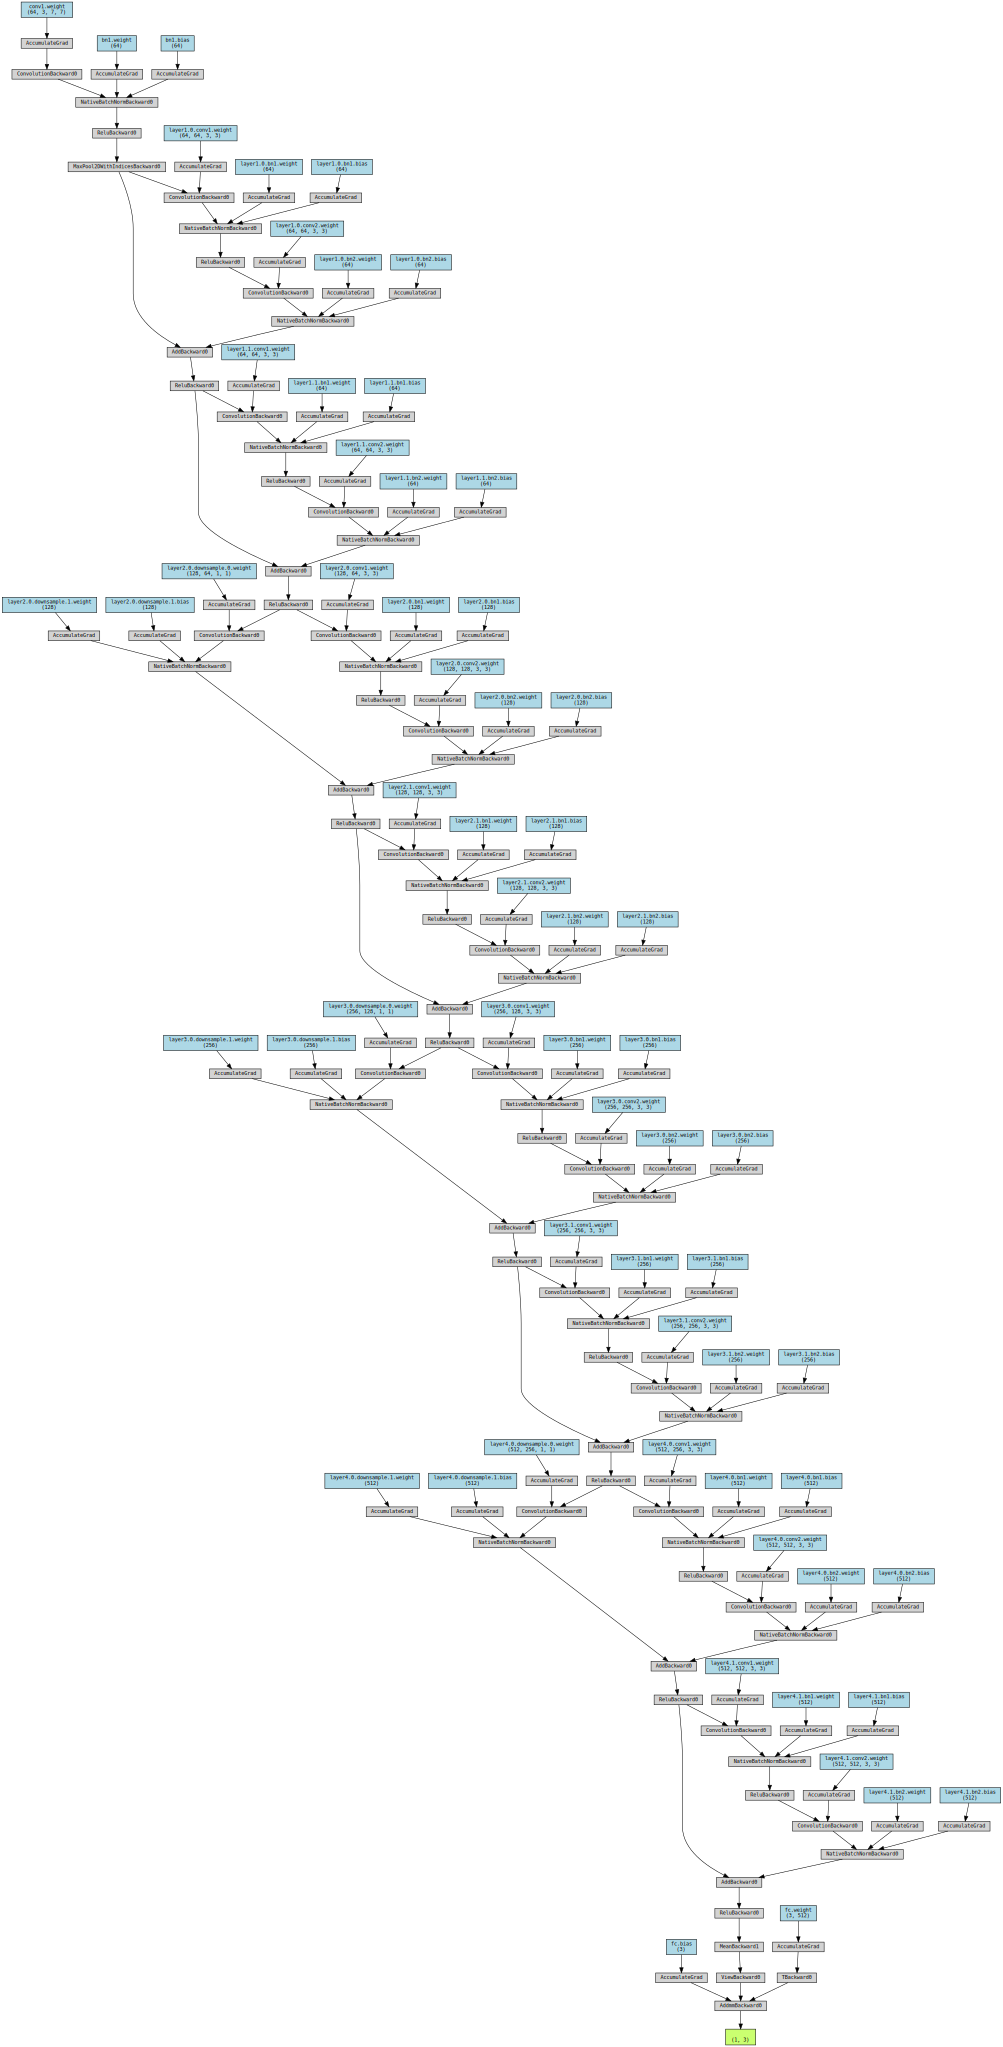

In [18]:
import torch
import timm
from torchviz import make_dot

# Load the ResNet model
resnet = timm.create_model('resnet18', pretrained=True, num_classes=3)

# Create a dummy input tensor (batch_size=1, channels=3, height=224, width=224)
dummy_input = torch.randn(1, 3, 224, 224)

# Perform a forward pass to get model output
output = resnet(dummy_input)

# Generate the visualization
dot = make_dot(output, params=dict(resnet.named_parameters()))
dot.render("resnet_model", format="png")  # Saves the visualization as a PNG file
dot  # Display the graph in Jupyter Notebook

In [19]:
# Step 8: Define Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)

In [20]:
num_classes = len(dataset.classes)
print(f"Number of classes: {num_classes}")  # Should be 3 for (Eczema, Psoriasis, Seborrheic_Keratoses)

Number of classes: 3


In [21]:
# @title Default title text
# # Step 9: Initialize MLflow
# mlflow.set_experiment('resnet_experiment')

# with mlflow.start_run():
#     mlflow.log_param("Model", "ResNet18")

#     # Step 10: Train Model with tqdm Progress Bar
#     num_epochs = 50
#     for epoch in range(num_epochs):
#         resnet.train()
#         running_loss = 0.0
#         correct = 0
#         total = 0

#         progress_bar = tqdm(train_dataloder, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

#         for inputs, labels in progress_bar:
#             inputs, labels = inputs.to(device), labels.to(device)

#             optimizer.zero_grad()
#             outputs = resnet(inputs)
#             loss = criterion(outputs, labels)

#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()
#             _, predicted = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#             progress_bar.set_postfix(loss=loss.item(), acc=100 * correct / total)

#         epoch_loss = running_loss / len(train_dataloder)
#         epoch_acc = 100 * correct / total

#         mlflow.log_metric("train_loss", epoch_loss, step=epoch)
#         mlflow.log_metric("train_accuracy", epoch_acc, step=epoch)

#         print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

#     # Step 11: Evaluate Model
#     resnet.eval()
#     y_pred = []
#     y_true = []

#     with torch.no_grad():
#         for inputs, labels in test_dataloader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = resnet(inputs)

#             _, predicted = torch.max(outputs, 1)
#             y_pred.extend(predicted.cpu().numpy())
#             y_true.extend(labels.cpu().numpy())

#     # Step 12: Compute Metrics
#     classification_rep = classification_report(y_true, y_pred, target_names=dataset.classes, output_dict=True)
#     print(classification_rep)
#     cm = confusion_matrix(y_true, y_pred)

#     # Log classification report
#     with open("classification_report.txt", "w") as f:
#         f.write(str(classification_rep))
#     mlflow.log_artifact("classification_report.txt")

#     # Log Confusion Matrix
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
#     disp.plot(cmap="Blues")
#     plt.savefig("confusion_matrix.png")
#     mlflow.log_artifact("confusion_matrix.png")

#     # Log additional metrics
#     mlflow.log_metric("cohen_kappa", cohen_kappa_score(y_true, y_pred))
#     mlflow.log_metric("matthews_corrcoef", matthews_corrcoef(y_true, y_pred))

#     # Log the trained model
#     mlflow.pytorch.log_model(resnet, "model")

#     print("\nFinal Test Accuracy:", 100 * np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true))
#     print(f"Cohen Kappa: {cohen_kappa_score(y_true, y_pred):.4f}")
#     print(f"Matthews Correlation Coefficient: {matthews_corrcoef(y_true, y_pred):.4f}")

Epoch 1/20: 100%|██████████| 240/240 [01:12<00:00,  3.33it/s, acc=56.5, loss=0.761]


Epoch 1/20, Loss: 0.9309, Accuracy: 56.50%, Precision: 0.5656, Recall: 0.5632, F1-score: 0.5622


Epoch 2/20: 100%|██████████| 240/240 [00:54<00:00,  4.42it/s, acc=62.8, loss=0.622]


Epoch 2/20, Loss: 0.8290, Accuracy: 62.81%, Precision: 0.6288, Recall: 0.6280, F1-score: 0.6272


Epoch 3/20: 100%|██████████| 240/240 [00:51<00:00,  4.69it/s, acc=64.9, loss=0.884]


Epoch 3/20, Loss: 0.7880, Accuracy: 64.91%, Precision: 0.6481, Recall: 0.6492, F1-score: 0.6477


Epoch 4/20: 100%|██████████| 240/240 [00:53<00:00,  4.49it/s, acc=65.8, loss=0.695]


Epoch 4/20, Loss: 0.7698, Accuracy: 65.82%, Precision: 0.6594, Recall: 0.6574, F1-score: 0.6575


Epoch 5/20: 100%|██████████| 240/240 [00:52<00:00,  4.55it/s, acc=66.8, loss=0.822]


Epoch 5/20, Loss: 0.7518, Accuracy: 66.79%, Precision: 0.6688, Recall: 0.6670, F1-score: 0.6671


Epoch 6/20: 100%|██████████| 240/240 [00:51<00:00,  4.71it/s, acc=67.1, loss=0.67]


Epoch 6/20, Loss: 0.7442, Accuracy: 67.10%, Precision: 0.6723, Recall: 0.6706, F1-score: 0.6706


Epoch 7/20: 100%|██████████| 240/240 [00:50<00:00,  4.72it/s, acc=67.7, loss=0.65]


Epoch 7/20, Loss: 0.7263, Accuracy: 67.66%, Precision: 0.6773, Recall: 0.6762, F1-score: 0.6762


Epoch 8/20: 100%|██████████| 240/240 [00:52<00:00,  4.60it/s, acc=68.5, loss=0.717]


Epoch 8/20, Loss: 0.7198, Accuracy: 68.50%, Precision: 0.6863, Recall: 0.6842, F1-score: 0.6846


Epoch 9/20: 100%|██████████| 240/240 [00:50<00:00,  4.73it/s, acc=68.7, loss=0.575]


Epoch 9/20, Loss: 0.7132, Accuracy: 68.65%, Precision: 0.6873, Recall: 0.6861, F1-score: 0.6863


Epoch 10/20: 100%|██████████| 240/240 [00:52<00:00,  4.58it/s, acc=69.1, loss=0.627]


Epoch 10/20, Loss: 0.7068, Accuracy: 69.10%, Precision: 0.6913, Recall: 0.6906, F1-score: 0.6905


Epoch 11/20: 100%|██████████| 240/240 [00:51<00:00,  4.66it/s, acc=69.8, loss=0.903]


Epoch 11/20, Loss: 0.7008, Accuracy: 69.84%, Precision: 0.6991, Recall: 0.6980, F1-score: 0.6981


Epoch 12/20: 100%|██████████| 240/240 [00:53<00:00,  4.50it/s, acc=69.9, loss=0.715]


Epoch 12/20, Loss: 0.6924, Accuracy: 69.92%, Precision: 0.6997, Recall: 0.6989, F1-score: 0.6988


Epoch 13/20: 100%|██████████| 240/240 [00:50<00:00,  4.73it/s, acc=70.1, loss=0.639]


Epoch 13/20, Loss: 0.6898, Accuracy: 70.07%, Precision: 0.7015, Recall: 0.7001, F1-score: 0.7003


Epoch 14/20: 100%|██████████| 240/240 [00:51<00:00,  4.68it/s, acc=70.2, loss=0.977]


Epoch 14/20, Loss: 0.6881, Accuracy: 70.15%, Precision: 0.7024, Recall: 0.7008, F1-score: 0.7011


Epoch 15/20: 100%|██████████| 240/240 [00:52<00:00,  4.60it/s, acc=70.3, loss=0.7]


Epoch 15/20, Loss: 0.6921, Accuracy: 70.27%, Precision: 0.7034, Recall: 0.7023, F1-score: 0.7024


Epoch 16/20: 100%|██████████| 240/240 [00:52<00:00,  4.61it/s, acc=70.6, loss=0.854]


Epoch 16/20, Loss: 0.6800, Accuracy: 70.63%, Precision: 0.7066, Recall: 0.7062, F1-score: 0.7060


Epoch 17/20: 100%|██████████| 240/240 [00:53<00:00,  4.52it/s, acc=70.1, loss=0.628]


Epoch 17/20, Loss: 0.6837, Accuracy: 70.13%, Precision: 0.7016, Recall: 0.7011, F1-score: 0.7010


Epoch 18/20: 100%|██████████| 240/240 [00:49<00:00,  4.81it/s, acc=70.3, loss=0.66]


Epoch 18/20, Loss: 0.6807, Accuracy: 70.27%, Precision: 0.7036, Recall: 0.7021, F1-score: 0.7023


Epoch 19/20: 100%|██████████| 240/240 [00:50<00:00,  4.74it/s, acc=71.1, loss=0.559]


Epoch 19/20, Loss: 0.6698, Accuracy: 71.09%, Precision: 0.7123, Recall: 0.7103, F1-score: 0.7110


Epoch 20/20: 100%|██████████| 240/240 [00:51<00:00,  4.65it/s, acc=70.4, loss=0.794]


Epoch 20/20, Loss: 0.6745, Accuracy: 70.40%, Precision: 0.7050, Recall: 0.7035, F1-score: 0.7039
{'Eczema': {'precision': 0.7427937915742794, 'recall': 0.5756013745704467, 'f1-score': 0.648596321393998, 'support': 582.0}, 'Psoriasis': {'precision': 0.6343001261034048, 'recall': 0.7279305354558611, 'f1-score': 0.6778975741239892, 'support': 691.0}, 'Seborrheic_Keratoses': {'precision': 0.7566765578635015, 'recall': 0.7906976744186046, 'f1-score': 0.7733131159969674, 'support': 645.0}, 'accuracy': 0.7028154327424401, 'macro avg': {'precision': 0.7112568251803952, 'recall': 0.6980765281483041, 'f1-score': 0.6999356705049848, 'support': 1918.0}, 'weighted avg': {'precision': 0.7083752625941824, 'recall': 0.7028154327424401, 'f1-score': 0.7010934528618495, 'support': 1918.0}}


2025/03/07 08:19:24 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/03/07 08:19:37 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-01-14; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-spark-connect'}
2025/03/07 08:19:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Final Test Accuracy: 70.281543274244
Cohen Kappa: 0.5508
Matthews Correlation Coefficient: 0.5540
Precision: 0.7113, Recall: 0.6981, F1-score: 0.6999
🏃 View run Resnet18-70-30 at: https://dagshub.com/prachipancholi1/Dermnet.mlflow/#/experiments/0/runs/473d1bcca51640b58281848cec5c1148
🧪 View experiment at: https://dagshub.com/prachipancholi1/Dermnet.mlflow/#/experiments/0


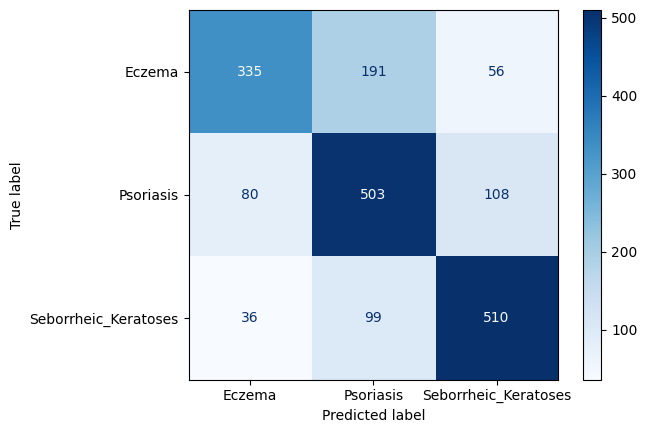

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef

# Step 9: Initialize MLflow
mlflow.set_experiment('resnet_experiment')

with mlflow.start_run():
    mlflow.log_param("Model", "ResNet18")

    # Step 10: Train Model with tqdm Progress Bar
    num_epochs = 20
    for epoch in range(num_epochs):
        resnet.train()
        running_loss = 0.0
        correct = 0
        total = 0
        y_pred_train = []
        y_true_train = []

        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            resnet = resnet.to(device)
            outputs = resnet(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store predictions and true labels for metrics calculation
            y_pred_train.extend(predicted.cpu().numpy())
            y_true_train.extend(labels.cpu().numpy())

            progress_bar.set_postfix(loss=loss.item(), acc=100 * correct / total)


        # Compute per-epoch metrics
        epoch_loss = running_loss / len(train_dataloader)
        epoch_acc = 100 * correct / total
        epoch_precision = precision_score(y_true_train, y_pred_train, average="macro", zero_division=1)
        epoch_recall = recall_score(y_true_train, y_pred_train, average="macro", zero_division=1)
        epoch_f1 = f1_score(y_true_train, y_pred_train, average="macro", zero_division=1)
        epoch_cohen_kappa = cohen_kappa_score(y_true_train, y_pred_train)
        epoch_matthews_corrcoef = matthews_corrcoef(y_true_train, y_pred_train)

        # Log metrics to MLflow
        mlflow.log_metric("train_loss", epoch_loss, step=epoch)
        mlflow.log_metric("train_accuracy", epoch_acc, step=epoch)
        mlflow.log_metric("train_precision", epoch_precision, step=epoch)
        mlflow.log_metric("train_recall", epoch_recall, step=epoch)
        mlflow.log_metric("train_f1_score", epoch_f1, step=epoch)
        mlflow.log_metric("train_cohen_kappa", epoch_cohen_kappa, step=epoch)
        mlflow.log_metric("train_matthews_corrcoef", epoch_matthews_corrcoef, step=epoch)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, Precision: {epoch_precision:.4f}, Recall: {epoch_recall:.4f}, F1-score: {epoch_f1:.4f}")

    # Step 11: Evaluate Model
    resnet.eval()
    y_pred = []
    y_true = []

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet(inputs)

            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    # Step 12: Compute Final Test Metrics
    classification_rep = classification_report(y_true, y_pred, target_names=dataset.classes, output_dict=True)
    print(classification_rep)
    cm = confusion_matrix(y_true, y_pred)

    # Log classification report
    with open("classification_report.txt", "w") as f:
        f.write(str(classification_rep))
    mlflow.log_artifact("classification_report.txt")

    # Log Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
    disp.plot(cmap="Blues")
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Compute and Log Final Metrics
    test_precision = precision_score(y_true, y_pred, average="macro", zero_division=1)
    test_recall = recall_score(y_true, y_pred, average="macro", zero_division=1)
    test_f1 = f1_score(y_true, y_pred, average="macro", zero_division=1)
    test_cohen_kappa = cohen_kappa_score(y_true, y_pred)
    test_matthews_corrcoef = matthews_corrcoef(y_true, y_pred)

    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)
    mlflow.log_metric("test_f1_score", test_f1)
    mlflow.log_metric("test_cohen_kappa", test_cohen_kappa)
    mlflow.log_metric("test_matthews_corrcoef", test_matthews_corrcoef)

    # Log the trained model
    mlflow.pytorch.log_model(resnet, "model")

    print("\nFinal Test Accuracy:", 100 * np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true))
    print(f"Cohen Kappa: {test_cohen_kappa:.4f}")
    print(f"Matthews Correlation Coefficient: {test_matthews_corrcoef:.4f}")
    print(f"Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-score: {test_f1:.4f}")
